In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns ;sns.set()

In [2]:
df = pd.read_csv('../Data/CleanData/InitialClean.csv',dtype='object',index_col=0)
df.columns

Index(['APGAR1', 'APGAR2', 'AREA', 'AREA_RESIDENCIA_HAB', 'ASIS_MED',
       'CAUSA_667', 'CAU_HOMOL', 'CERT_EXPEDIDO_POR', 'COD_DPTO', 'C_BAS1',
       'C_DIR1', 'DEPTO_RESIDENCIA', 'EDAD_MADRE', 'EDAD_PADRE', 'EST_CIVM',
       'FECHA_NACM', 'GRU_ED1', 'IDADMISALUD', 'IDCLASADMI', 'IDFACTORRH',
       'IDHEMOCLAS', 'IDPERTET', 'MANERA_MUERTE', 'MOMENTO_MUERTE', 'NIV_EDUM',
       'NIV_EDUP', 'NUM_CONSUL', 'N_EMB', 'N_HIJOSM', 'N_HIJOSV', 'NacidoVivo',
       'PAIS_RESIDENCIA', 'PARTO_ATENDIDO_POR', 'PESO', 'PROFESION',
       'RESULTADO_EMB', 'SEG_SOCIAL', 'SEXO', 'SITIO_EVENTO', 'TALLA',
       'TIEMPO_GESTACION', 'TIPO_EMBARAZO', 'TIPO_PARTO', 'ULTCURMAD',
       'ULTCURPAD', 'ID_BIRTH', 'ID_RESID', 'ID_VIOL', 'C_MUERTE', 'DATE'],
      dtype='object')

## Start looking at some seemingly easy to understand variables:

PESO, AREA_RES, EDAD_MADRE, SEXO, TALLA, T_GES

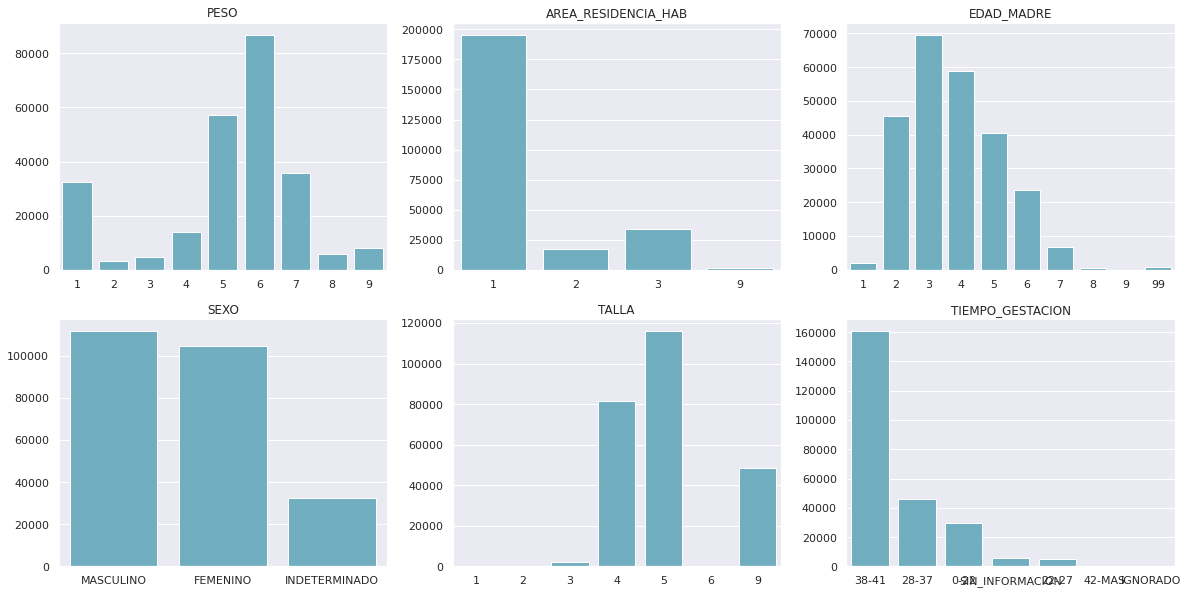

In [3]:
cols = ['PESO','AREA_RESIDENCIA_HAB','EDAD_MADRE','SEXO','TALLA','TIEMPO_GESTACION']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    axi.set_title(col)
    cnt_peso = df[col].value_counts()
    sns.barplot(cnt_peso.index,cnt_peso.values,ax=axi,color='c')
    
plt.savefig('../Plots/InitialDists.png')
plt.show()

PESO has quite an interesting distribution. It looks normal if we exclude 1 and 9, but 1 is a large peak. It may be related to underweighting. There is also the fact that 1 represents the 0-1000 g range, while every other number represents a 500 g range. Even then, it is still a prominent peak.

EDAD_MADRE is skewed to the right, with the peak at 3 (20-24 yo). It is worrying the quantity of pregnancies from 10-14 yo (bin 1). The range 15-19 is also quite large.

Also, most of the births occur at municipal headers (1), SEXO is almost 50/50.

T_GES: Has peaks at 1 and 4 (<22 weeks, 38-41 weeks). The latter is about the normal time of a pregnancy, but the first roughly indicates the quantity of early deliveries. It would be interesting to study the influence of this variable on viability of newborn.

Most of the TALLA are missing, so it probably is not a very informative variable.

In [4]:
#pedro

## Now let us discriminate distributions.

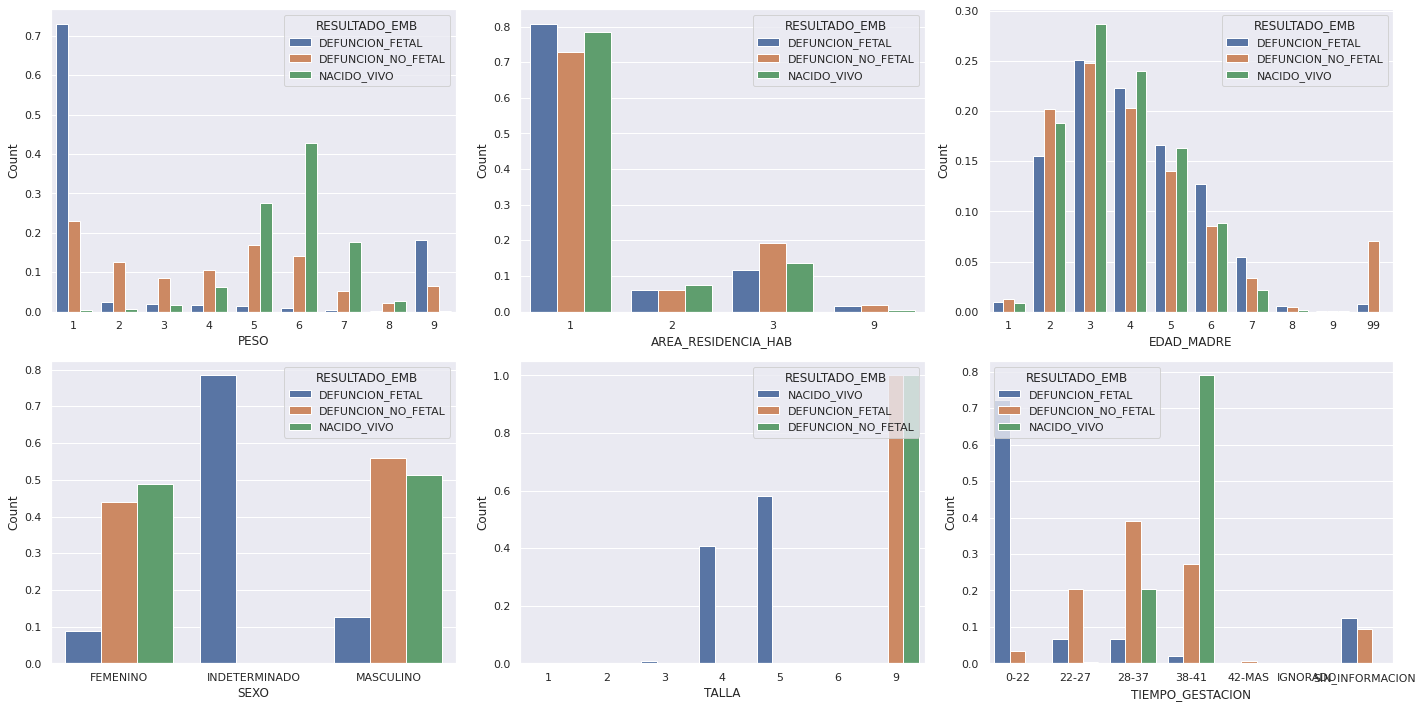

In [5]:
cols = ['PESO','AREA_RESIDENCIA_HAB','EDAD_MADRE','SEXO','TALLA','TIEMPO_GESTACION']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    cnt = (df[[col,'RESULTADO_EMB']]
                .groupby([col,'RESULTADO_EMB'])
                .apply(len).reset_index()
                .rename(columns={0:'Count'}))

    #Compute normalized distribution
    totals =  cnt.groupby('RESULTADO_EMB').apply(sum).Count  #Total elements
    for ind in totals.index:
        cnt.loc[cnt['RESULTADO_EMB']==ind,'Count'] /= totals[ind]
    
    sns.barplot(data=cnt,x=col,y='Count',hue='RESULTADO_EMB',ax=axi)
    
plt.tight_layout()
plt.savefig('../Plots/InitialDiscrimDists.png')
plt.show()

The first plot explains the observations on the above cells: The PESO distribution of the newborns IS normal, the peak at 1 is due almost exclusively to fetal deaths (orange). A small peak (green) cal also be seen here, which probably makes PESO a good factor indicating newborn viability. AREA and EDAD_MADRE have very similar distributions. 

From these plots we can start identifying correlations (at least to proof the consistency of the data). We can see that the peak at 3 in SEXO (undetermined) is exclusively due to fetal deaths. From the T_GES plot we can see that most of the fetal deaths occur before 22 weeks. Depending on the time of differentiation of sex, this correlation may be due to the lack of differentiation at the time of the death of these fetuses.

There might be some correlation between TALLA and T_GES. There are two similar peaks in both of the plots, which may indicate some correspondence.

There doesn't seem to be substantial differences among distributions in AREA_RES, that is, the fact that some mother lives at a city or in a rural place doesn't seem to determine whether the fetus lives or dies.

An additional (and more subtle) insight: in the EDAD_MADRE plot we can see that the distribution for fetal deaths is a bit more spread out than that for the newborns. What this means is that older women do get pregnant, but the probability of them having an abortion increases.

# Questions (check the boxes as you answer questions)

- [x] Do APGAR{1,2} actually predict anything?
- [x] Is there any difference between newborns whose mothers reside in a different place where the kids are born (ID_BIRTH != ID_RESID)?
- [x] Is the distribution of ages of the fathers different from that of the mothers? Discriminate between newborn, deaths, etc. See if there's any correlation.
- [x] Look at GRU_ED1. How is the distribution of ages of newborn deaths?
- [x] IDPERTET is cultural-racial identification. Are distributions any different?
- [ ] Influence of MUL_PARTO
- [ ] Compare NIV_EDUM, NIV_EDUP. Are these distributions any different? Look for combinations of these two, maybe data can already show inequity?
- [ ] N_EMB, N_HIJOSM, N_HIJOSV on outcome. Distribution, geographical distribution, correlation with race, culture, age
- [ ] Eliminate OCUPACION (check first)
- [ ] Look at SITIO_EVENTO. Make data cleaning worth it!
- [ ] Corr with TIPO_PARTO

I guess that's it for now

### Q1: Do APGAR{1,2} actually predict anything?

Number of 99s: 109089
APGAR1 ['NACIDO_VIVO']
APGAR2 ['NACIDO_VIVO']


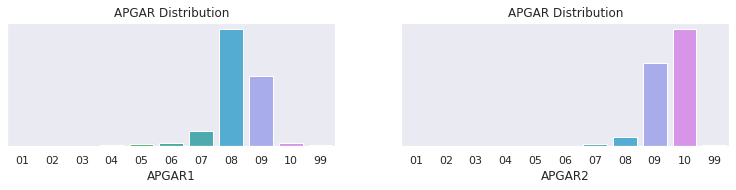

In [6]:
#Let's first look at APGAR{1,2}

#Check for 99s. They should appear ONLY for fetal deaths.
num99s = df['APGAR1'].value_counts().iloc[0]
print(f"Number of 99s: {num99s}")

cols = ['APGAR1','APGAR2']
for col in cols:
    print(col , df.loc[df[col]!='99','RESULTADO_EMB'].unique())


fig = plt.figure(figsize=(20,5))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    cnt = (df.loc[df['RESULTADO_EMB'] == 'NACIDO_VIVO',[col,'AREA']].groupby(col)
            .apply(len).reset_index().rename(columns={0:'Count'}))
    sns.barplot(data=cnt,x=col,y='Count')
    axi.set_ylabel('')
    axi.set_yticks([])
    axi.set_title('APGAR Distribution')

So, it turns out both fetal and non-fetal deaths datasets are full of 99s on these columns, so we can't predict anything. We can, however, look a the distribution of this variable.

For what can be seen from these plots, it looks like a higher APGAR value is more common (and I guess better because these kids were actually born alive)

### Q2: Is there any difference between newborns whose mothers reside in a different place where the kids are born (ID_BIRTH != ID_RESID)?

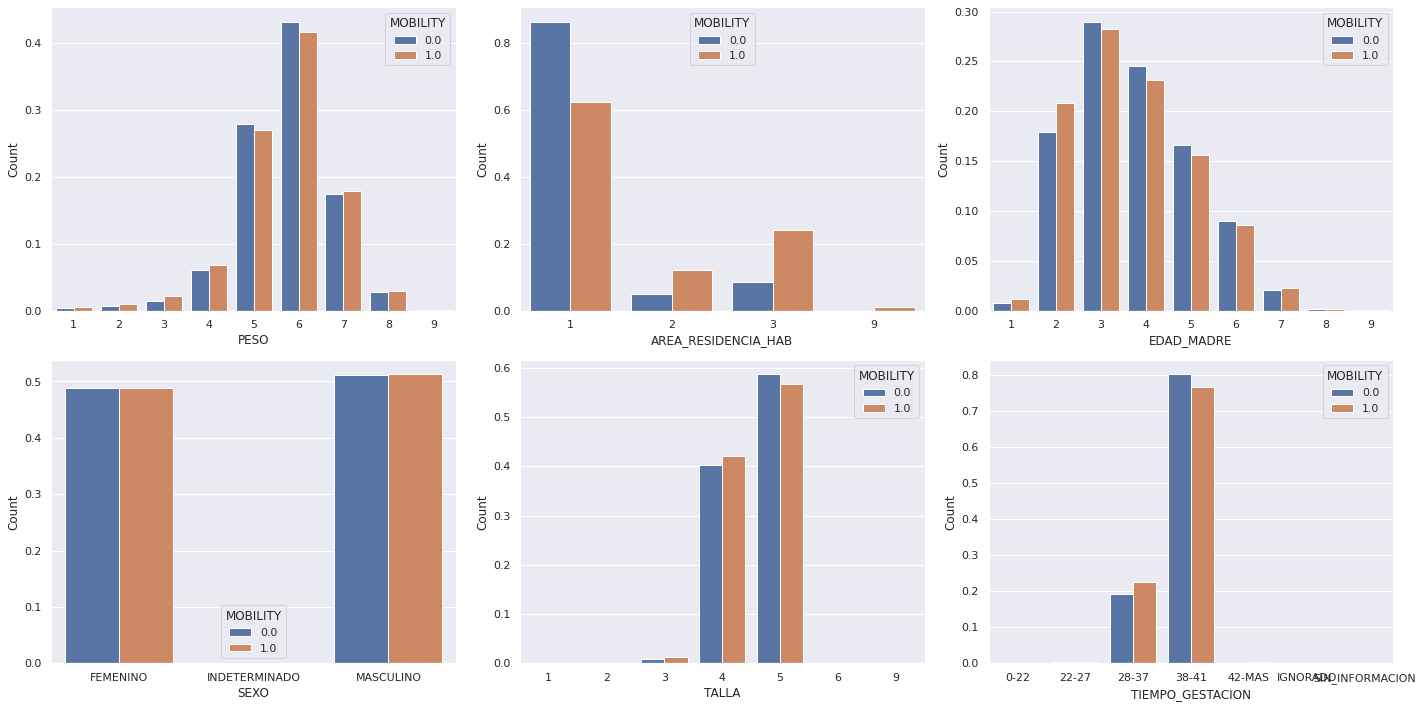

In [7]:
#Create new column for this variable.
#Actually we'd have to segregate those whose death was violent but lets do it like this for now.
df['MOBILITY'] = (df['ID_BIRTH'] != df['ID_RESID'])*1.0

cols = ['PESO','AREA_RESIDENCIA_HAB','EDAD_MADRE','SEXO','TALLA','TIEMPO_GESTACION']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    cnt = (df.loc[df['RESULTADO_EMB']=='NACIDO_VIVO',[col,'MOBILITY']]
                .groupby([col,'MOBILITY'])
                .apply(len).reset_index()
                .rename(columns={0:'Count'}))
    #Compute normalized distribution
    totals =  cnt.groupby('MOBILITY').apply(sum).Count  #Total elements
    for ind in totals.index:
        cnt.loc[cnt['MOBILITY']==ind,'Count'] /= totals[ind]
    
    sns.barplot(data=cnt,x=col,y='Count',hue='MOBILITY',ax=axi)
    
plt.tight_layout()
#plt.savefig('../Plots/InitialDiscrimDists.png')
plt.show()

The insight here is that mothers that travel in order to give birth usually come from rural areas (which is not really surprising though). Every other distribution behaves practically the same.

Also, from plot 3 it can be seen that most of the 10-19 yo mothers have to move from their place of residence in order to give birth. These two observations lead us to conjecture that teenage pregnancies are more common in rural areas. Can this information be extracted from the data?

### Q3: Is the distribution of ages of the fathers different from that of the mothers? Discriminate between newborn, deaths, etc. See if there's any correlation.

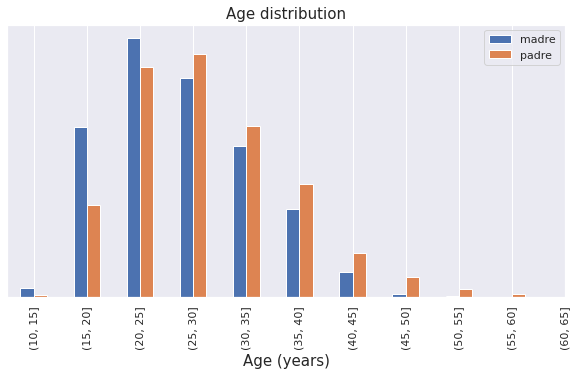

In [8]:
#Make categories for EDAD_PADRE
df['EDAD_PADRE_cat'] = pd.cut(df['EDAD_PADRE'].astype(int),bins=range(10,105,5))

#Same for EDAD_MADRE

#First replace categories by a representative value
rep_edadmadre = {'1':12,'2':17,'3':22,'4':27,'5':33,'6':37,'7':41,'8':47,'9':52,'99':99}
vals = df['EDAD_MADRE'].replace(rep_edadmadre.keys(),rep_edadmadre.values()).astype('category')
   
#Now do the same as before
df['EDAD_MADRE_cat'] = pd.cut(vals.values,bins=range(10,105,5))

#Produce normalized distribution fro both madre and padre
madre = df.groupby('EDAD_MADRE_cat')['AREA'].count().rename('madre')
madre /= madre.sum()
padre = df.groupby('EDAD_PADRE_cat')['AREA'].count().rename('padre')
padre /= padre.sum()

#Plot
fig,ax = plt.subplots(figsize=(10,5))
pd.concat([madre,padre],names=['Madre','Padre'],axis=1).plot(kind='bar',ax=ax)
ax.set_xlim(right=10)
ax.set_xlabel('Age (years)',fontsize=15)
ax.set_title('Age distribution',fontsize=15)
ax.set_yticks([])
plt.show()

We can clearly see that the distributions are different. As expected (using our knowledge of our country), the male parent is usually older than the female parent. The peak is at about the same ages, but the father distribution is considerably less skewed to the right and has a larger spread to the right.

The second part of the question is to look for correlations with target variable 

In [9]:
padre = df.groupby(['EDAD_PADRE_cat','RESULTADO_EMB'])['AREA'].count().rename('Count').reset_index()

padre.loc[padre['Count']!=0,'RESULTADO_EMB'].unique()

array(['NACIDO_VIVO'], dtype=object)

This can't be done since there is only data for born alive.

### Q4: Look at GRU_ED1. How is the distribution of ages of newborn deaths?

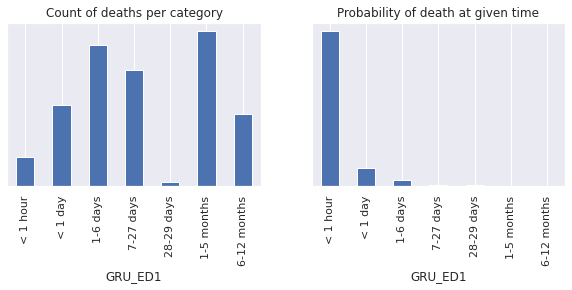

In [10]:
counts = df.groupby('GRU_ED1')['AREA'].count()

range_size = [1/24.,1., 5., 20., 1., 5.*30, 6.*30] #days
count_norm = counts.copy()
for i,cat in enumerate(counts.index):
    count_norm.loc[cat] /= range_size[i]
    
fig,ax = plt.subplots(1,2,figsize=(10,3))
counts.plot(kind='bar',ax=ax[0])
count_norm.plot(kind='bar',ax=ax[1])

ax[0].set_title('Count of deaths per category')
ax[1].set_title('Probability of death at given time')

categories = ['< 1 hour','< 1 day','1-6 days','7-27 days','28-29 days','1-5 months','6-12 months']
ax[0].set_xticklabels(categories,rotation=90)
ax[1].set_xticklabels(categories,rotation=90)
ax[0].set_yticks([])
ax[1].set_yticks([])

plt.show()

We have two very different plots here. The first shows that most of the deaths of < 1 yo people occur between 1-6 days and 1-5 months old. However, if we compare the time ranges where these events occur, we see that the early hours determine crucially the survivance of the newborn, as the probability of death peaks at less than 1 hour.

This is interesting since we now know where to look for a problem: what is going on with newborns between 1-5 months? Many of them die at this stage. However, we also know now that we must take special care to less than 1 hour old newborns, since this is where the probability of them dying is higher.

### Q5: IDPERTET is cultural-racial identification. Are distributions any different?

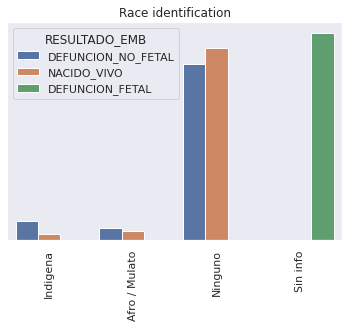

In [11]:
g = df.groupby(['IDPERTET','RESULTADO_EMB'])['AREA'].count().rename('count').reset_index()
#Normalize
for cat in g['RESULTADO_EMB'].unique():
    tot = g.loc[g['RESULTADO_EMB']==cat,'count'].sum()
    g.loc[g['RESULTADO_EMB']==cat,'count'] /= tot

#This excludes the following categories 'Rom','Raizal','Palenquero'
#Since they just appear as blank spaces
g = g[g['count']>0.01] 

fig,ax = plt.subplots()
sns.barplot(data=g,x='IDPERTET',y='count',hue='RESULTADO_EMB',ax=ax)
ax.set_xticklabels(['Indigena','Afro / Mulato','Ninguno','Sin info'],rotation=90)
ax.set_title('Race identification')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

We can see an important difference: Indigenous and afro people have a larger probability of a post-birth death than people identifying themselves with none of these races. This category is what we may identify in general as "white" people. Geographical correlation of these variables is important in orden to more confidently determine whether there is a systematic discrimination issue in the country, or this trend comes from different cultural aspects, among others.

It is a shame we don't have data for fetal deaths. This data can however be obtained at a municipality level, so we can really do a study of this kind with geographical correlations.

Discuss: is it worthy to make distributions for mother's age, etc, discriminating by this variable?

# Let us stop this analysis here, and start thinking on some geographical plots

In [1]:
import plotly.express as px
import geopandas as gpd

In [3]:
import numpy as np
import pandas as pd

# Department codes:

05= Antioquia,
08= Atlántico,
11= Bogotá,
13= Bolivar,
15= Boyaca,
17=Caldas,
18= Caqueta,
19=Cauca,
20= Cesar,
23= Cordoba,
25=Cundinamarca,
27= Choco,
41= Huila,
44= La guajira,
47= Magdalena,
50= Meta,
52= Nariño,
54= Norte de Santander,
63= Quindio,
66= Risaralda,
68= Santander,
70= Sucre,
73= Tolima,
76= Valle del Cauca,
81= Arauca,
85= Casanare,
86= Putumayo,
88= Archipiélago de San Andrés, Providencia y Santa Catalina,
91= Amazonas,
94= Guainía,
95= Guaviare,
97= Vaupés,
99= Vichada

In [2]:
geo_df = gpd.read_file("../Data/GeoData/MGN_MPIO_POLITICO.shp")
geo_df.columns
#MPIO_CCNCT is unique munic identifier: DPTO+MUNIC

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CRSLC', 'MPIO_NAREA',
       'MPIO_CCNCT', 'MPIO_NANO', 'DPTO_CNMBR', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [4]:
#Find centroid of municip. so we can make colored plots in folium
geo_df['centroid'] = geo_df['geometry'].centroid
geo_df['longitude'] = geo_df['centroid'].apply(lambda x: np.array(x)[0])
geo_df['latitude'] = geo_df['centroid'].apply(lambda x: np.array(x)[1])
geo_df.drop('centroid',axis=1,inplace=True)

centroids = geo_df.groupby('DPTO_CCDGO').apply(lambda x: x[x['MPIO_CCDGO']=='001'])
for dpto in geo_df['DPTO_CCDGO'].unique():
    geo_df.loc[geo_df['DPTO_CCDGO']==dpto,['longitude','latitude']] = centroids.loc[dpto,['longitude','latitude']].values[0]
    

<ipython-input-4-867237fda35e>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df['centroid'] = geo_df['geometry'].centroid


#### Convert this file to geoJson. It's just easier to plot (need to run only once)

In [5]:
tojson = geo_df[['MPIO_CNMBR','MPIO_CCNCT','geometry']].set_index('MPIO_CCNCT')
tojson.index.name = None
tojson.to_file("../Data/GeoData/MGN_MPIO_POLITICO.geojson", driver='GeoJSON',index=True)

In [6]:
geo_df = pd.DataFrame(geo_df.drop(columns='geometry'))

In [ ]:
import json
with open("../Data/GeoData/MGN_MPIO_POLITICO.geojson") as geo:
    geojson = json.loads(geo.read())

In [ ]:
geojson

### A slice of the total df must be taken in order to plot interactive maps. Attempting to plot the entire map of Colombia grained by municipio would take too long and probably crash.

### Suggestion: if you are to plot all of Colombia, use departments (that's another dataset), if you are to plot by municipio then do it for only one departamento, or use non-interactive options such as gdp.plot

In [6]:
df_dpt = geo_df[geo_df['DPTO_CCDGO']=='91']
long,lat = df_dpt.loc[:,['longitude','latitude']].iloc[0]

In [7]:
px.choropleth_mapbox(df_dpt,                         #Data
        locations='MPIO_CCNCT',                   #Column containing the identifiers used in the GeoJSON file 
        color='MPIO_NAREA',                       #Column giving the color intensity of the region
        geojson=geojson,
        featureidkey = 'properties.MPIO_CCNCT',
        zoom=3,                                   #Zoom
        mapbox_style="carto-positron",            #Mapbox style, for different maps you need a Mapbox account and a token
        center={"lat": lat, "lon":long},          #Center
        color_continuous_scale="Viridis",         #Color Scheme
        opacity=0.5,                              #Opacity of the map
)


KeyboardInterrupt



In [17]:
df_dpt

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CCNCT,MPIO_NANO,DPTO_CNMBR,Shape_Leng,Shape_Area,longitude,latitude
208,91,001,LETICIA,Decreto 352 de Feb 20 de 1964,6182.416560,91001,2018,AMAZONAS,3.880001,0.500702,-70.045137,-3.530059
209,91,263,EL ENCANTO,Decreto 274 de Mayo 28 de 1953,10897.546705,91263,2018,AMAZONAS,8.052697,0.885325,-70.045137,-3.530059
210,91,405,LA CHORRERA,Decreto 274 de Mayo 28 de 1953,12726.867908,91405,2018,AMAZONAS,9.105101,1.033583,-70.045137,-3.530059
211,91,407,LA PEDRERA,Decreto 274 de Mayo 28 de 1953,13668.214894,91407,2018,AMAZONAS,7.376291,1.105198,-70.045137,-3.530059
212,91,430,LA VICTORIA,ORD 12 DE JULIO 9 DE 1996,1432.794978,91430,2018,AMAZONAS,2.483170,0.116086,-70.045137,-3.530059
213,91,460,MIRITÍ - PARANÁ,Decreto 274 de Mayo 28 de 1953,16867.532538,91460,2018,AMAZONAS,6.448395,1.366866,-70.045137,-3.530059
214,91,530,PUERTO ALEGRÍA,ORD 24 DE AGOSTO 01 DE 1997,8494.182494,91530,2018,AMAZONAS,4.777815,0.690133,-70.045137,-3.530059
215,91,536,PUERTO ARICA,ORD 23 DE AGOSTO 01 DE 1997,13791.326986,91536,2018,AMAZONAS,8.677672,1.118032,-70.045137,-3.530059
216,91,540,PUERTO NARIÑO,Decreto 106 de Enero 18 de 1984,1509.204302,91540,2018,AMAZONAS,1.968859,0.122363,-70.045137,-3.530059
217,91,669,PUERTO SANTANDER,Decreto 274 de Mayo 28 de 1953,14731.088495,91669,2018,AMAZONAS,10.636046,1.195233,-70.045137,-3.530059
